<a href="https://colab.research.google.com/github/alexchilton/CAS_Project_2_protein_autoencoders/blob/main/cleaned_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><strong>Protein autoencoder</strong></h1>

<h5 align="center">
    <a href="https://github.com/alexchilton/CAS_Project_2_protein_autoencoders">
        https://github.com/alexchilton/CAS_Project_2_protein_autoencoders
    </a>
    <br>
    Alex C., Lara N.
</h5>


# Libraries

In [ ]:
!pip install torch_geometric

In [ ]:
import os
import collections
import copy
import itertools
import json
import logging
import time
from datetime import datetime
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
from tqdm import tqdm
#from google.colab import drive


from PIL import Image
from IPython.display import display


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GATConv, global_mean_pool

import networkx as nx

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from scipy.stats import wasserstein_distance


In [ ]:
!pip install biopython

In [ ]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# For Colab only_move to function file directory, load and go back to content /drive
#%cd /content/drive/MyDrive/CAS_AML/function_files
from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info
from graphvae import ProteinGraphVAE
#%cd /content/drive

# Configuration

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [ ]:
# # Define the file for a demo protein structure
# pdb_file = '/content/drive/MyDrive/CAS_AML/datasets/all_nano_structures_single_domain/1zv5.pdb'

# # Define the directory containing the PDB files
# pdb_directory = '/content/drive/MyDrive/CAS_AML/datasets/all_nano_structures_single_domain_clean'

# # Define the file containing amino acid information
# aa_info_file = '/content/drive/MyDrive/CAS_AML/info_files/aa_mass_letter.csv'

# # Preprocessed protein dataframes
# output_dir = "/content/drive/MyDrive/CAS_AML/outputs/processed_dataframes"

# output_model_dir="/content/drive/MyDrive/CAS_AML/models"


In [ ]:
# on local

# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes
output_dir = "processed_dataframes"
output_model_dir="model"

# Preprocessing

Data are preprocessed from PDB files.   
Each PDB file is extracted and converted in a dataframe containing infrmation on the 3D structure (x, y, z coordinates of the aminoacids), on the neighborhood (number of surrounding aminoacids with average, and max distance) and on the additional small molecules close to that residue that have an impact on the structure.   
Distances and position in the 3D space are computed through the position of the alpha carbon mapped with the aminoacid mass to have an information on the aminoacid residue in that position, with relatively smaller dataframes.

In [ ]:
img = Image.open("/content/drive/MyDrive/CAS_AML/info_files/alpha_carbon.jpg")
img1=Image.open("/content/drive/MyDrive/CAS_AML/info_files/nanobody.jpg")

base_width = 600
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)

base_width = 600
wpercent = (base_width / float(img1.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img1 = img1.resize((base_width, hsize), Image.Resampling.LANCZOS)



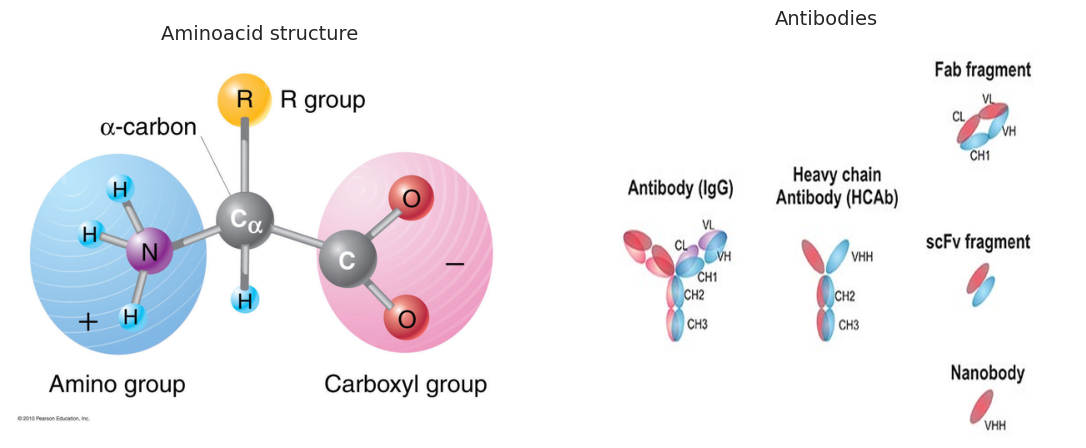

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))


ax1.imshow(img)
ax1.grid(None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Aminoacid structure', fontsize=14, pad=20)


ax2.imshow(img1)
ax2.grid(None)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Antibodies', fontsize=14, pad=20)

plt.tight_layout(pad=4)  # layout
plt.show()



In [ ]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [ ]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1646/1646 [14:06<00:00,  1.95it/s] 


In [ ]:
dataframes[100]

('data/all_nano_structures_single_domain_clean/6qpg.pdb',
                X          Y           Z   Avg_Mass  Avg_Neighbor_Dist  \
 0      36.323002  -3.720000   27.447001  149.20784           3.798889   
 1      34.318001  -2.347000   30.367001  147.13074           3.804916   
 2      35.535000   1.252000   30.068001  133.10384           4.203339   
 3      34.761002   1.298000   26.339001  165.19184           4.117101   
 4      31.247999  -0.021000   27.004999  117.14784           3.807043   
 ...          ...        ...         ...        ...                ...   
 8798  245.561005 -49.153000 -143.811005  146.14594           3.813642   
 8799  248.477997 -46.709999 -143.660995   75.06714           4.038929   
 8800  251.311005 -45.792000 -146.042007  119.12034           3.802752   
 8801  255.044998 -45.397999 -145.507004  117.14784           4.184459   
 8802  257.760986 -42.911999 -146.505005  119.12034           4.312732   
 
       Max_Neighbor_Dist  Neighbor_Count  Small_Mole

In [ ]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


# Graph conversion

In [ ]:
def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
    )
    return data


In [ ]:
graphs = []
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing: 100%|██████████| 1646/1646 [00:36<00:00]


# Graph representation and reality

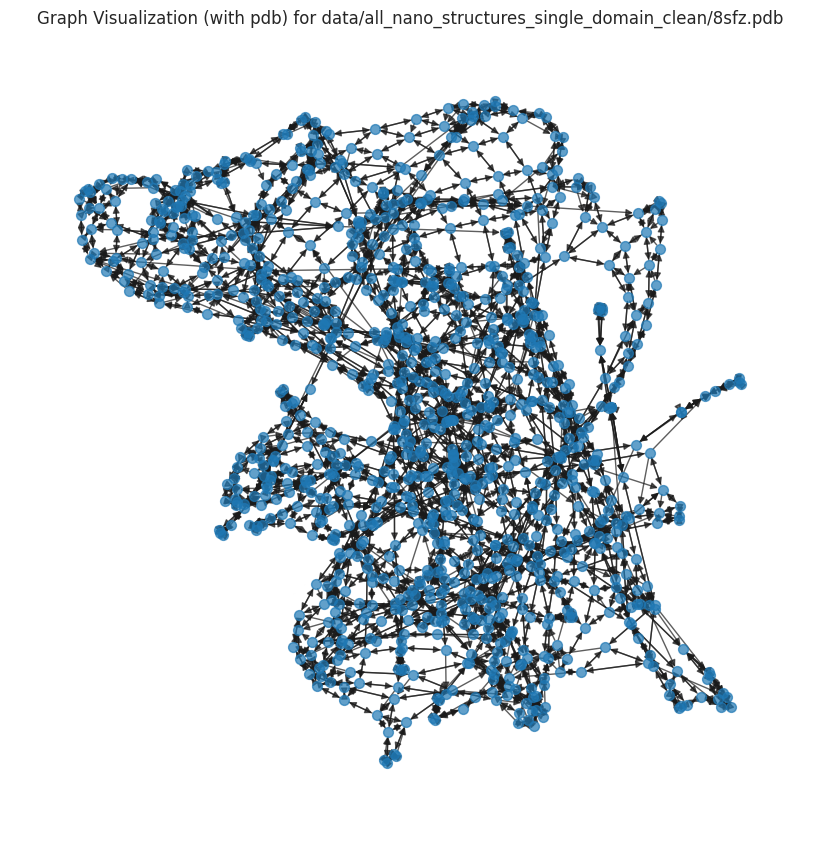

In [ ]:
def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization (with pdb) for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[20]
visualize_nanobody_graph(data, pdb_file)


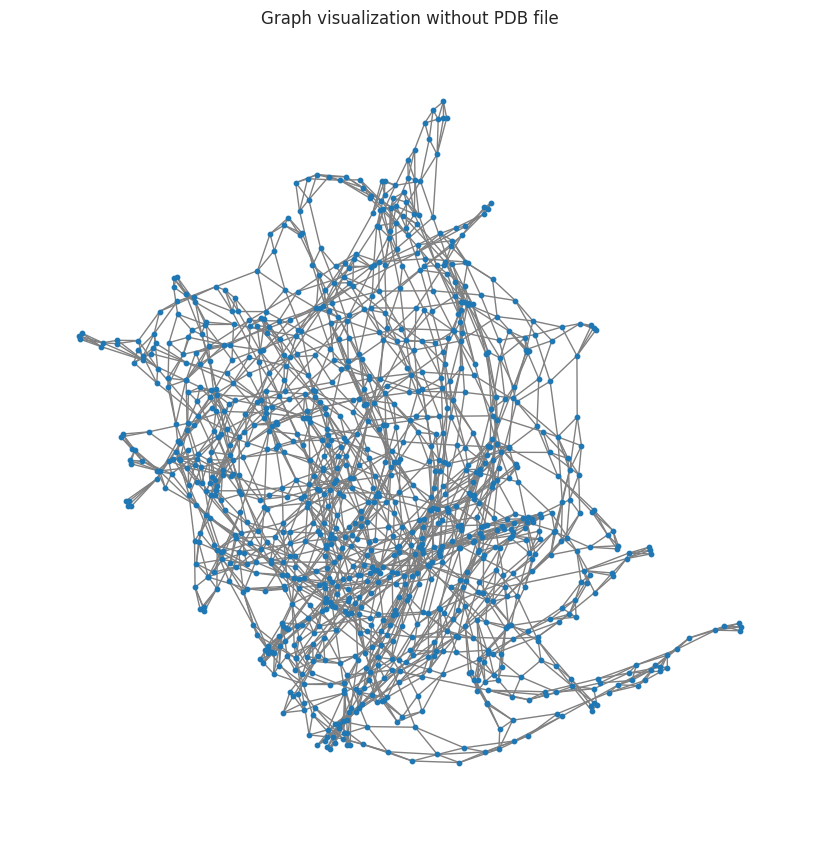

In [ ]:
pdb, graph_data = graphs[20]
nx_graph = to_networkx(graph_data, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, node_size=10, edge_color="gray")
plt.title('Graph visualization without PDB file')
plt.show()

Representation of a preprocessed protein in form of graph. Important element are the asymmetry and teh metrics.

In [ ]:
metrics = calculate_graph_metrics(graph_data)
print("Metrics for Graph-Protein")
for key, value in metrics.items():
    print(f"  {key}: {value}")

Metrics for Graph-Protein
  num_nodes: 1058
  num_edges: 2426
  avg_degree: 4.586011342155009
  edge_density: 0.004338705148680236
  clustering_coeff: 0.3730323761514688
  graph_diameter: inf
  avg_path_length: inf


In [ ]:
image_path_1 = "/content/drive/MyDrive/CAS_AML/info_files/nanobody.jpg"
image_path_2 = "/content/drive/MyDrive/CAS_AML/info_files/nanobody.jpg"
image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns
axes[0].imshow(image_1)
axes[0].axis('off')
axes[0].set_title("Image 1: Original")

axes[1].imshow(image_2)
axes[1].axis('off')
axes[1].set_title("Image 2: Plot")

plt.tight_layout()
plt.show()


# Dataloader and augmentation

In [ ]:
def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

In [ ]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

Dataset prepared:
Number of training graphs: 1316
Number of test graphs: 330
Number of features per node: 8
Feature means: tensor([129.2633,   3.9415,   4.2174,   3.1894,   1.8581,  89.7058,  92.3966,
         96.3327])
Feature stds: tensor([ 29.3618,   0.1919,   0.4701,   6.9553,   1.7267,  99.2087,  95.7911,
        101.8036])


In [ ]:
def augment_graph(graph, noise_level=0.01):
    """
    Augments a PyTorch Geometric graph by adding small random noise to node features
    and edge attributes.

    Parameters:
    - graph: PyG Data object to augment.
    - noise_level: Magnitude of noise to add to node features and edge attributes.

    Returns:
    - Augmented PyG Data object.
    """
    augmented_graph = graph.clone()

    # Add random noise to node features
    if graph.x is not None:
        augmented_graph.x += torch.randn_like(graph.x) * noise_level

    # Add random noise to edge attributes (e.g., distances)
    if graph.edge_attr is not None:
        augmented_graph.edge_attr += torch.randn_like(graph.edge_attr) * noise_level

    return augmented_graph


In [ ]:
# Augment graphs in the training dataset
augmented_train_dataset = [augment_graph(g) for g in train_loader.dataset]

# Create a new DataLoader with augmented data
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)

# Graph Variational Autoencoder (GraphVAE)

In [ ]:
def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [ ]:
def kl_annealing_factor(epoch, warmup_epochs=10, min_weight=0.0001, max_weight=1.0):
    """Compute KL annealing factor that gradually increases from min_weight to max_weight"""
    if epoch < warmup_epochs:
        return min_weight + (max_weight - min_weight) * (epoch / warmup_epochs)
    return max_weight

def compute_orthogonal_regularization(mu, lambda_ortho=0.1):
    """Compute orthogonality regularization for the latent space"""
    batch_size = mu.size(0)
    mu_normalized = F.normalize(mu, p=2, dim=1)  # Normalize each embedding
    correlation = torch.mm(mu_normalized.t(), mu_normalized) / batch_size
    identity = torch.eye(correlation.size(0), device=correlation.device)
    ortho_loss = lambda_ortho * torch.sum((correlation - identity) ** 2)
    return ortho_loss

def train_model(model, train_loader, test_loader, device, num_epochs=100,
                min_beta=0.0001, max_beta=0.01, warmup_epochs=10, lambda_ortho=0.1):
    """
    Train VAE model with KL annealing and orthogonal regularization
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")
    print(f"KL annealing: {min_beta} -> {max_beta} over {warmup_epochs} epochs")
    print(f"Orthogonal regularization strength: {lambda_ortho}")

    history = {
        'train': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': [],
            'beta': []  # Track KL weight
        },
        'test': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []
        }
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Get current KL weight from annealing schedule
        current_beta = kl_annealing_factor(epoch, warmup_epochs, min_beta, max_beta)
        epoch_losses['beta'] = current_beta

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Add orthogonality regularization
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)

                # Combine losses with annealed KL weight
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"Ortho loss: {ortho_loss.item():.4f}")
                        print(f"Current beta: {current_beta:.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                epoch_losses['total_loss'] += loss.item()
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                epoch_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}',
                    'ortho': f'{ortho_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            if k != 'beta':  # Don't average the beta value
                epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                test_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}, '
              f'Ortho: {epoch_losses["ortho_loss"]:.4f}, '
              f'Beta: {current_beta:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, KL, and Ortho losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Total Loss')
            plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
            plt.plot(history['train']['kl_loss'], label='KL Loss')
            plt.plot(history['train']['ortho_loss'], label='Ortho Loss')
            plt.plot(history['train']['beta'], label='Beta (KL weight)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific losses (log scale)
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                values = [max(1e-10, abs(x)) for x in history['train'][k]]
                plt.semilogy(values, label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            # Plot 4: Training vs Validation losses
            plt.subplot(2, 2, 4)
            plt.plot(history['train']['total_loss'], label='Train Loss')
            plt.plot(history['test']['total_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

## Model instantiation and summary

In [ ]:
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
)

In [ ]:
# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_layers): ModuleList(
    (0): GATConv(8, 64, heads=4)
    (1): GATConv(256, 64, heads=2)
    (2): GATConv(128, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
  )
  (coo

In [ ]:
device=get_device()

In [ ]:
def visualize_latent_space_with_node_count_filtered(model, data_loader, device='cuda', method='tsne', perplexity=30, max_nodes=5000):
    """
    Visualize the latent space using t-SNE or PCA, filtering graphs with a maximum number of nodes.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).
    - max_nodes: Maximum number of nodes for graphs to be included in visualization.

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)

    latent_vectors = []
    node_counts = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)

            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                node_counts.extend([g.x.size(0) for g in batch.to_data_list()])  # Number of nodes per graph
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                node_counts.extend([g.x.size(0) for g in batch.to_data_list()])  # Number of nodes per graph

    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    node_counts = np.array(node_counts)

    # Filter graphs based on the number of nodes
    mask = node_counts <= max_nodes
    filtered_latent_vectors = latent_vectors[mask]
    filtered_node_counts = node_counts[mask]

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")

    reduced_latent = reducer.fit_transform(filtered_latent_vectors)
    print(f"Filtered node counts: {filtered_node_counts.min()} - {filtered_node_counts.max()}")

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=filtered_node_counts,  # Use filtered node counts as labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Node Counts')
    plt.title(f'Latent Space Visualization ({method.upper()}) - Filtered by Nodes ≤ {max_nodes}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()


## Visualization of the latent space before training

Filtered node counts: 102 - 4743


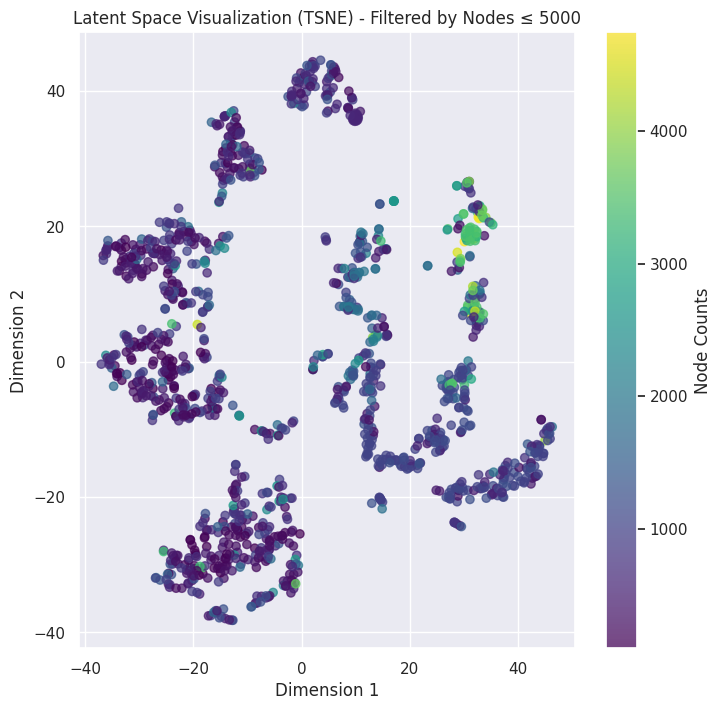

In [ ]:
visualize_latent_space_with_node_count_filtered(
    model=model,
    data_loader=augmented_train_loader,
    device=device,
    method='tsne',
    perplexity=30,
    max_nodes=5000
)

Filtered node counts: 102 - 4743


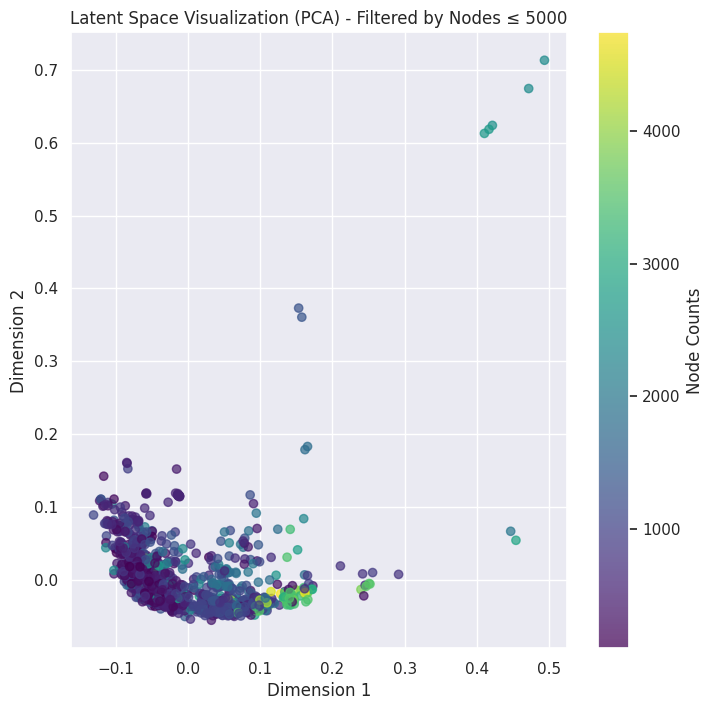

In [ ]:
visualize_latent_space_with_node_count_filtered(
    model=model,
    data_loader=augmented_train_loader,
    device=device,
    method='pca',
    max_nodes=5000
)

In [ ]:
def generate_protein_graphs(
    model,
    num_samples=5,
    nodes_per_graph=200,
    norm_params=None,
    device='cuda',
    k=10,
    temperature=1.0
):
    model.eval()
    model = model.to(device)

    # Handle normalization parameters
    feature_means, feature_stds = norm_params
    feature_means = feature_means.clone().detach().to(device)
    feature_stds = feature_stds.clone().detach().to(device)

    generated_graphs = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels).to(device) * temperature

            # Placeholder edge_index for decoding
            edge_index = torch.tensor(
                [[i, (i + 1) % nodes_per_graph] for i in range(nodes_per_graph)],
                dtype=torch.long
            ).t().contiguous().to(device)

            # Decode features
            decoded_features, _ = model.decode(
                z,
                num_nodes=nodes_per_graph,
                edge_index=edge_index
            )

            # Unnormalize features
            decoded_features = (decoded_features * feature_stds) + feature_means

            # Extract coordinates (ensure they are 2D)
            coords = decoded_features[0, :, -3:].cpu().numpy()

            # Create edges using k-NN
            nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
            distances, indices = nbrs.kneighbors(coords)

            edge_index = []
            edge_attr = []
            for i in range(len(indices)):
                for j in range(1, k):
                    edge_index.append([i, indices[i, j]])
                    edge_attr.append([distances[i, j]])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
            edge_attr = torch.tensor(edge_attr, dtype=torch.float).to(device)

            # Create PyG Data object
            graph = Data(
                x=decoded_features[0],  # Use the first graph's features
                edge_index=edge_index,
                edge_attr=edge_attr
            )
            generated_graphs.append(graph)

    return generated_graphs



In [ ]:
graph_data = [g[1] for g in graphs]

generated_graphs = generate_protein_graphs(
    model=model,
    num_samples=2,  # No of graphs
    nodes_per_graph=1000,  # nodes per graph
    norm_params=norm_params,
    device=device,
    k=5,
    temperature=1.5
)

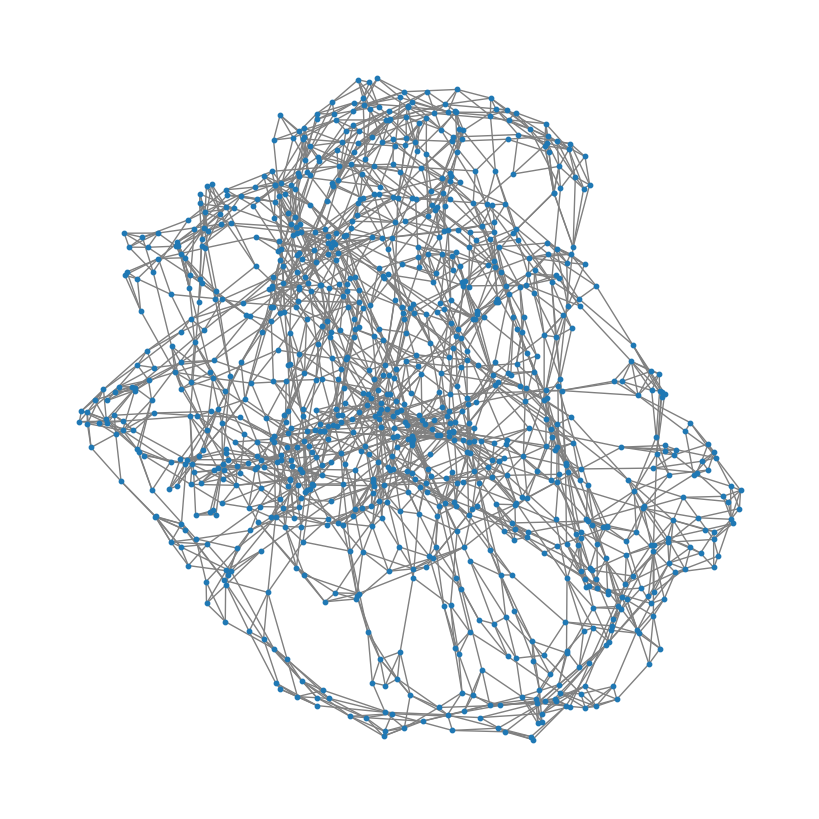

In [ ]:
graph = generated_graphs[0]
nx_graph = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, node_size=10, edge_color="gray")
plt.show()

In [ ]:
def calculate_graph_metrics(graph):
    # Convert PyG graph to NetworkX format
    nx_graph = to_networkx(graph, to_undirected=True)

    # Compute metrics
    num_nodes = nx_graph.number_of_nodes()
    num_edges = nx_graph.number_of_edges()
    avg_degree = sum(dict(nx_graph.degree()).values()) / num_nodes
    edge_density = nx.density(nx_graph)
    clustering_coeff = nx.average_clustering(nx_graph)
    graph_diameter = nx.diameter(nx_graph) if nx.is_connected(nx_graph) else float('inf')
    avg_path_length = nx.average_shortest_path_length(nx_graph) if nx.is_connected(nx_graph) else float('inf')

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "edge_density": edge_density,
        "clustering_coeff": clustering_coeff,
        "graph_diameter": graph_diameter,
        "avg_path_length": avg_path_length
    }

In [ ]:
# Apply this to each generated graph
for i, protein_graph in enumerate(generated_graphs, 1):
    metrics = calculate_graph_metrics(protein_graph)
    print(f"Metrics for Generated Protein {i}:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")

Metrics for Generated Protein 1:
  num_nodes: 1000
  num_edges: 2571
  avg_degree: 5.142
  edge_density: 0.005147147147147147
  clustering_coeff: 0.4132515873015873
  graph_diameter: 21
  avg_path_length: 9.792246246246247
Metrics for Generated Protein 2:
  num_nodes: 1000
  num_edges: 2616
  avg_degree: 5.232
  edge_density: 0.005237237237237237
  clustering_coeff: 0.40208730158730155
  graph_diameter: 22
  avg_path_length: 9.626656656656657


## Training

In [ ]:
#  #Adjust batch size for better gradient estimates
# train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
#     graphs,
#     batch_size=16,  # Increased batch size
#     train_ratio=0.8,
#     shuffle=True
# )

# Send the model to device (params same as before)
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
).to(device)


# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 100
model, history = train_model(
    model=model,
    train_loader=augmented_train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=num_epochs,
    min_beta=0.00001,    # Lower starting point
    max_beta=0.005,      # Slightly lower max
    warmup_epochs=25,    # Longer warmup
    lambda_ortho=0.1     # Keep orthogonal regularization as is
)

## Visualization of the latent space after training

Filtered node counts: 102 - 6112


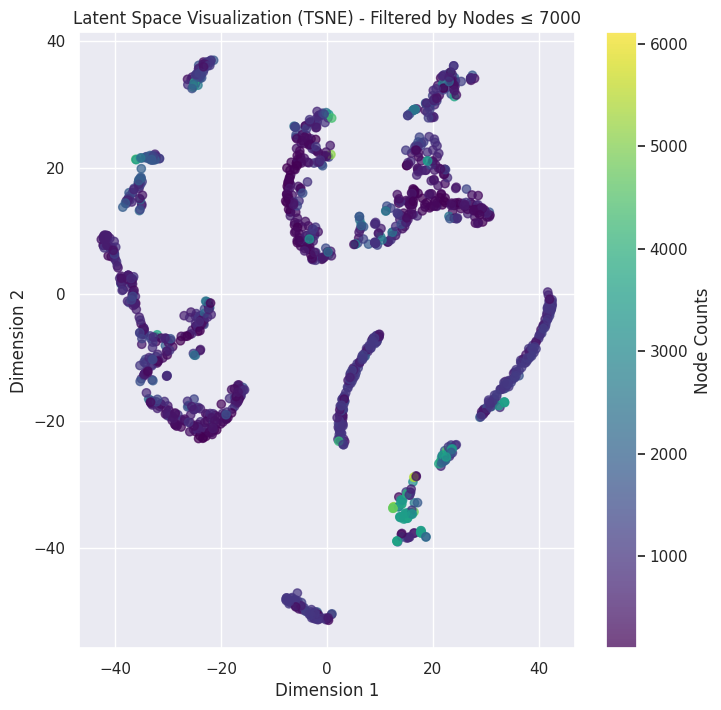

In [ ]:
visualize_latent_space_with_node_count_filtered(
    model=model,
    data_loader=augmented_train_loader,
    device=device,
    method='tsne',
    perplexity=30,
    max_nodes=7000
)

Filtered node counts: 102 - 6112


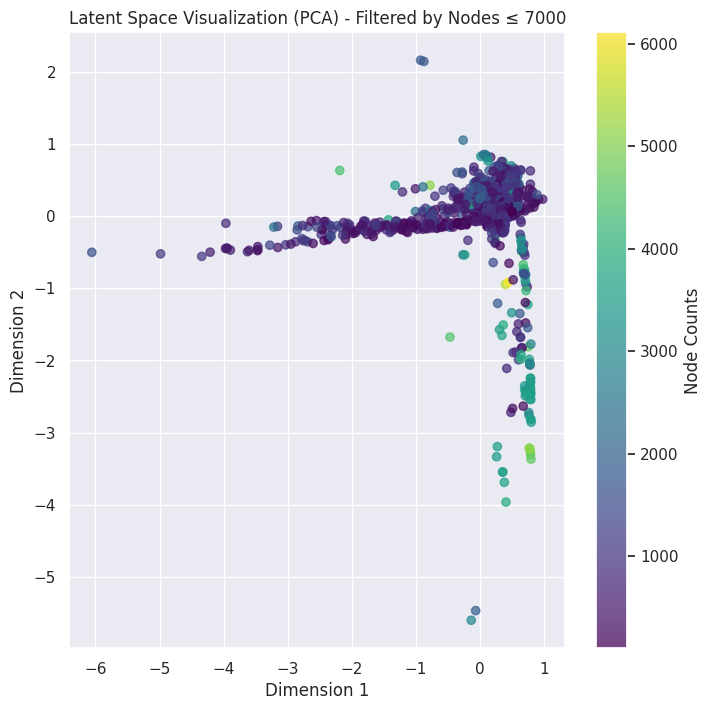

In [ ]:
visualize_latent_space_with_node_count_filtered(
    model=model,
    data_loader=augmented_train_loader,
    device=device,
    method='pca',
    max_nodes=7000
)

## Save the model

In [ ]:
# Assuming `model` is your trained ProteinGraphVAE instance
model_path = '/content/drive/MyDrive/CAS_AML/models/protein_graph_vae.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/CAS_AML/models/protein_graph_vae.pth


In [ ]:
# Save the model and norm_params together
save_path = '/content/drive/MyDrive/CAS_AML/models/protein_graph_vae_norm.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'norm_params': norm_params
}, save_path)

print(f"Model and normalization parameters saved to {save_path}")

## Analysis of the latent space

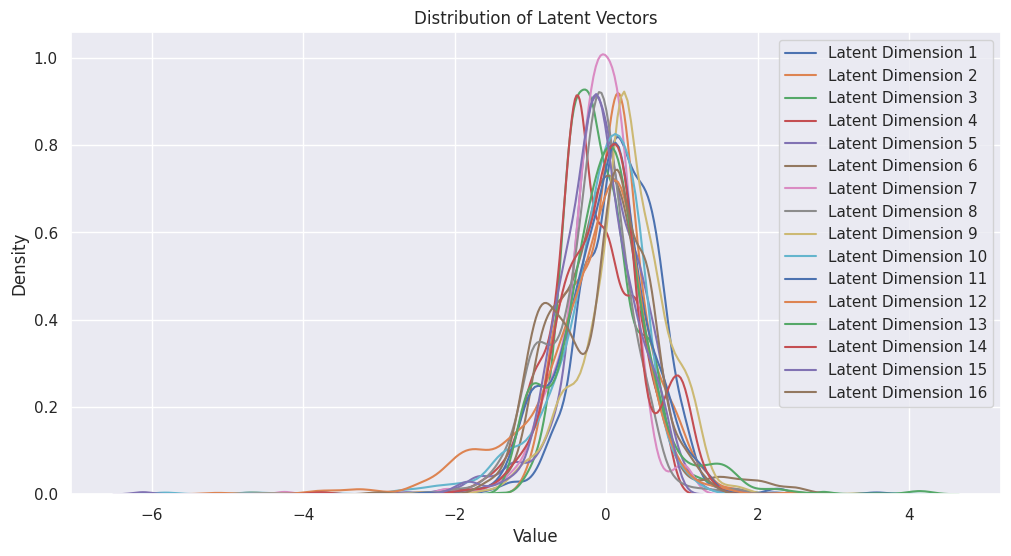

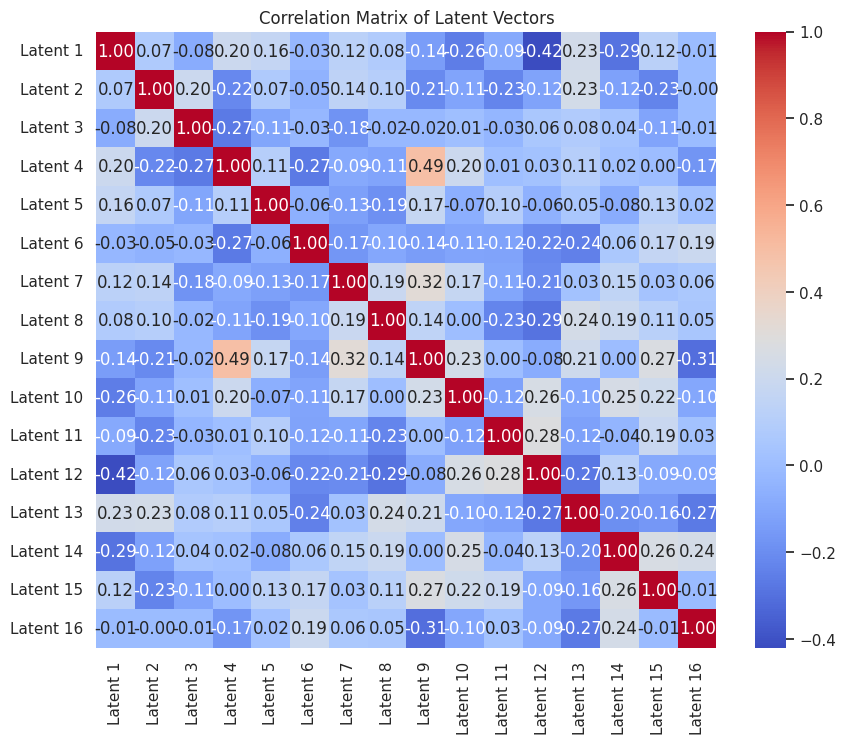

In [ ]:
def plot_latent_distribution_and_correlation(model, data_loader, device):
    """
    Plot the distribution of latent vectors and the correlation matrix.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
    """
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Plot the distribution of latent vectors
    plt.figure(figsize=(12, 6))
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(latent_vectors[:, i], label=f'Latent Dimension {i+1}')
    plt.title('Distribution of Latent Vectors')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Compute and plot the correlation matrix
    correlation_matrix = np.corrcoef(latent_vectors, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                xticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])],
                yticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])])
    plt.title('Correlation Matrix of Latent Vectors')
    plt.show()

# Example usage
plot_latent_distribution_and_correlation(model, augmented_train_loader, device)

In [ ]:
def analyze_latent_space(model, data_loader, device, save_path=None):
    """
    Analyze and visualize the latent space distributions and correlations

    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        save_path: Optional path to save visualizations
    """
    model.eval()
    latent_vectors = []

    # Collect latent vectors
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Distribution plots for each latent dimension
    ax1 = plt.subplot(231)
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(data=latent_vectors[:, i], ax=ax1, label=f'Dim {i}')
    ax1.set_title('Latent Dimension Distributions')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Correlation matrix
    ax2 = plt.subplot(232)
    corr_matrix = np.corrcoef(latent_vectors.T)
    sns.heatmap(corr_matrix,
                ax=ax2,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax2.set_title('Latent Dimension Correlations')

    # 3. PCA visualization
    ax3 = plt.subplot(233)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    scatter = ax3.scatter(pca_result[:, 0],
                          pca_result[:, 1],
                          alpha=0.5,
                          c=np.sum(latent_vectors**2, axis=1),  # Color by L2 norm
                          cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='L2 Norm')
    ax3.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 4. Box plot of latent dimensions
    ax4 = plt.subplot(234)
    ax4.boxplot(latent_vectors)
    ax4.set_title('Latent Dimension Ranges')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Value')

    # 5. Dimension-wise statistics
    ax5 = plt.subplot(235)
    stats = pd.DataFrame({
        'Mean': np.mean(latent_vectors, axis=0),
        'Std': np.std(latent_vectors, axis=0),
        'Median': np.median(latent_vectors, axis=0),
        'IQR': np.percentile(latent_vectors, 75, axis=0) - np.percentile(latent_vectors, 25, axis=0)
    })
    stats.index = [f'Dim {i}' for i in range(latent_vectors.shape[1])]
    sns.heatmap(stats,
                ax=ax5,
                cmap='viridis',
                annot=True,
                fmt='.2f')
    ax5.set_title('Dimension-wise Statistics')

    # 6. Wasserstein distance matrix between dimensions
    ax6 = plt.subplot(236)
    n_dims = latent_vectors.shape[1]
    wasserstein_mat = np.zeros((n_dims, n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            wasserstein_mat[i, j] = wasserstein_distance(
                latent_vectors[:, i],
                latent_vectors[:, j]
            )
    sns.heatmap(wasserstein_mat,
                ax=ax6,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax6.set_title('Wasserstein Distances\nbetween Dimensions')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Calculate additional metrics
    metrics = {
        'mean_correlation': np.mean(np.abs(corr_matrix - np.eye(n_dims))),
        'max_correlation': np.max(np.abs(corr_matrix - np.eye(n_dims))),
        'mean_wasserstein': np.mean(wasserstein_mat),
        'dimension_entropy': -np.sum(np.mean(latent_vectors, axis=0) * np.log(np.abs(np.mean(latent_vectors, axis=0)) + 1e-10)),
        'pca_explained_variance': pca.explained_variance_ratio_.sum()
    }

    return fig, metrics

def visualize_latent_traversal(model, data_loader, device, dim_idx=0, n_steps=10):
    """
    Visualize how changing a single latent dimension affects the reconstruction

    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        dim_idx: Index of dimension to traverse
        n_steps: Number of steps in traversal
    """
    model.eval()

    # Get a sample batch
    batch = next(iter(data_loader)).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        z = model.reparameterize(mu, logvar)

    # Create traversal values
    traversal_range = np.linspace(-3, 3, n_steps)
    reconstructions = []

    # Generate reconstructions
    with torch.no_grad():
        for value in traversal_range:
            z_new = z.clone()
            z_new[:, dim_idx] = value
            recon, edge_recon = model.decode(z_new, batch.x.size(0), batch.edge_index)
            reconstructions.append(recon.cpu().numpy())

    return np.array(reconstructions), traversal_range

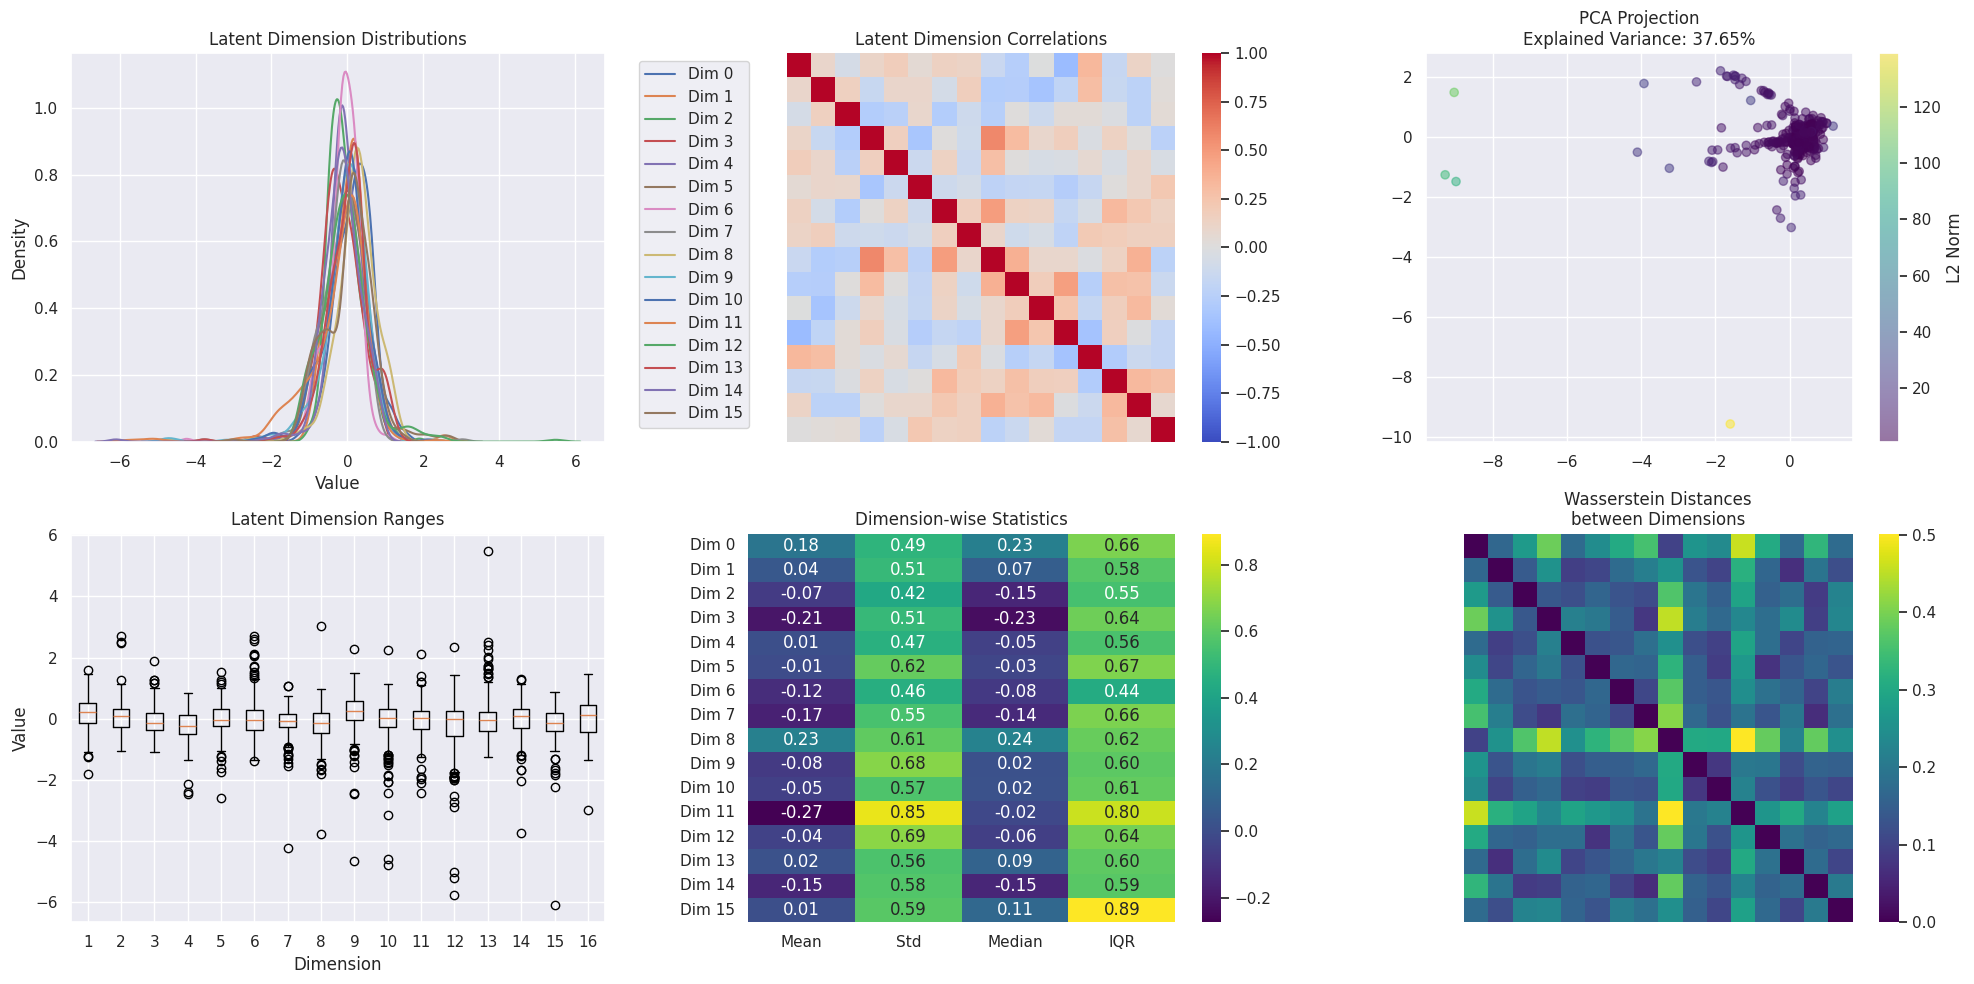

mean_correlation: 0.1556
max_correlation: 0.5826
mean_wasserstein: 0.1844
dimension_entropy: -1.3024
pca_explained_variance: 0.3765


In [ ]:
# After training your model
fig, metrics = analyze_latent_space(model, test_loader, device)
plt.show()

# Print latent space metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualize how changing dimension 0 affects reconstruction
reconstructions, traversal_values = visualize_latent_traversal(model, test_loader, device, dim_idx=0)

# Generator

## Load the model (activate for inference)

In [ ]:
# # Initialize your model
# model = ProteinGraphVAE(
#     in_channels=8,
#     hidden_channels=64,
#     latent_channels=16,
#     num_heads=4,
#     edge_dim=1
# )

# # Load the state dictionary
# model_path = '/content/drive/MyDrive/CAS_AML/models/protein_graph_vae.pth'
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# # Set the model to evaluation mode (if needed)
# model.eval()

# print(f"Model loaded from {model_path}")


In [ ]:
# # Model inference (with normalization parameters)

# # Load the model and norm_params
# checkpoint = torch.load('/content/drive/MyDrive/CAS_AML/models/protein_graph_vae.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# norm_params = checkpoint['norm_params']

# # Move the model to the appropriate device
# model.to(device)
# model.eval()

# print(f"Model and normalization parameters loaded successfully")


In [ ]:
generated_graphs = generate_protein_graphs(
    model=model,
    num_samples=5,  # n° graphs
    nodes_per_graph=3000,  # nodes per graph
    norm_params=norm_params,
    device=device,
    k=10,
    temperature=2.0)

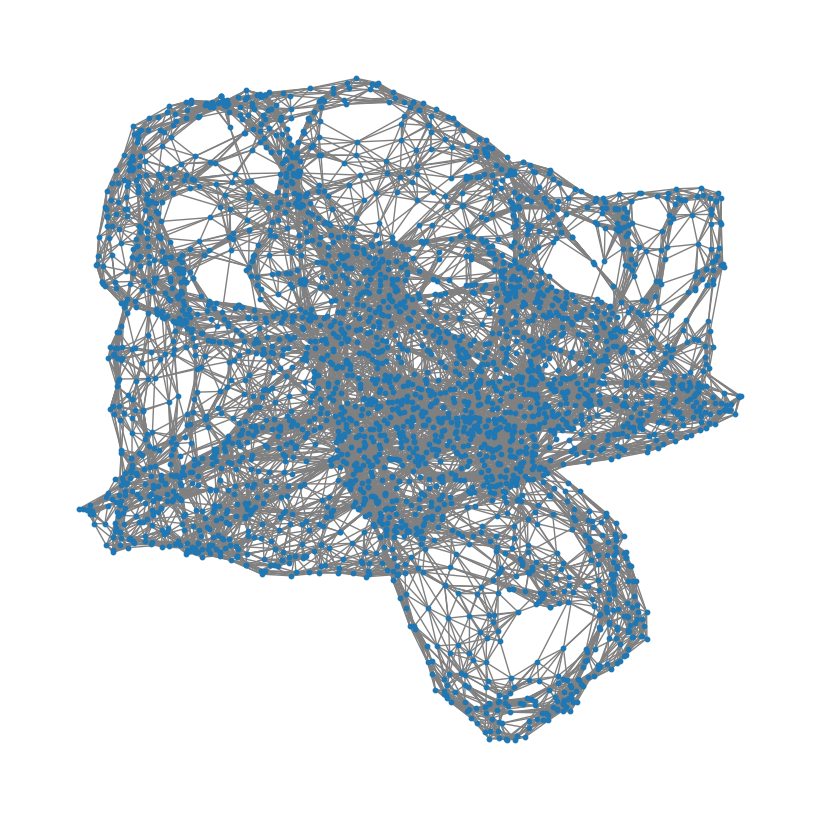

In [ ]:
graph = generated_graphs[0]
nx_graph = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, node_size=10, edge_color="gray")
plt.show()


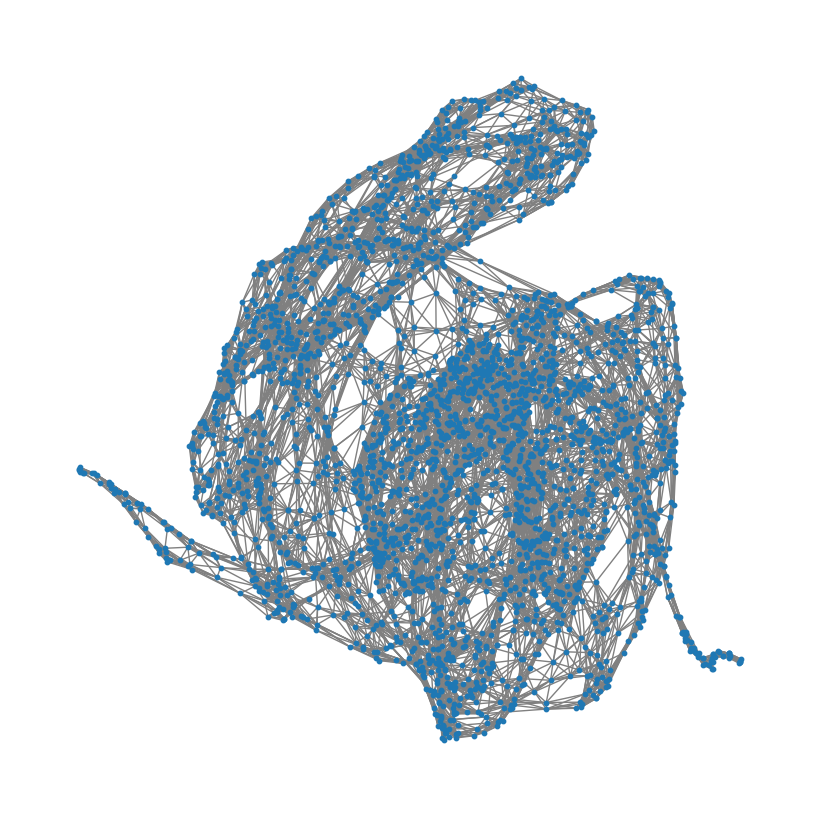

In [ ]:
graph = generated_graphs[1]
nx_graph = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, node_size=10, edge_color="gray")
plt.show()

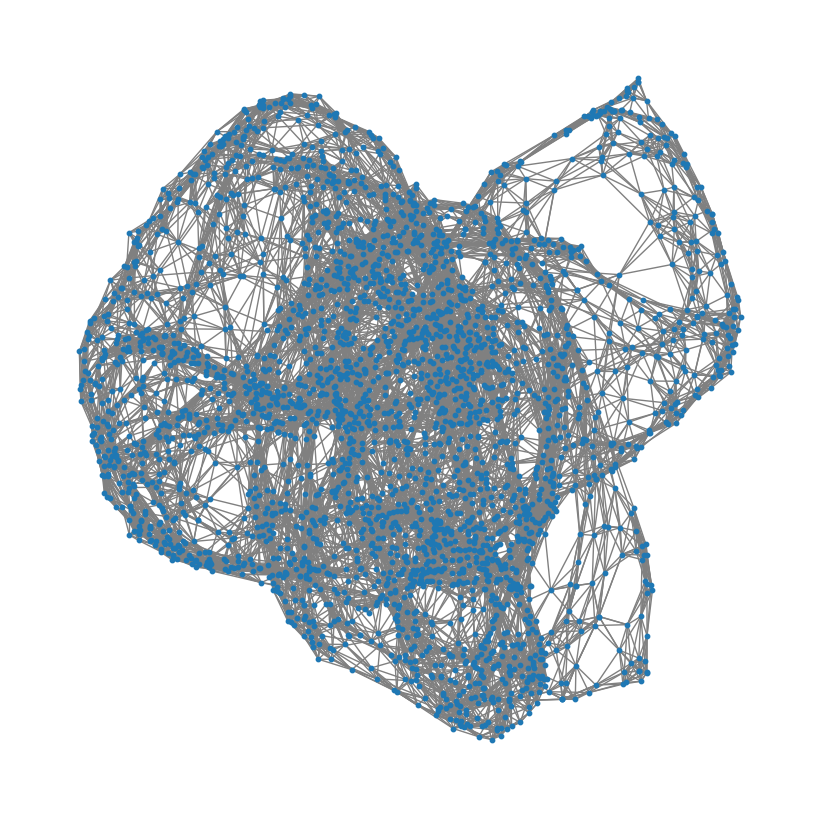

In [ ]:
graph = generated_graphs[2]
nx_graph = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, node_size=10, edge_color="gray")
plt.show()

## evaluate the generations

In [ ]:
# Apply this to each generated graph
for i, protein_graph in enumerate(generated_graphs, 1):
    metrics = calculate_graph_metrics(protein_graph)
    print(f"Metrics for Generated Protein {i}:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")



Metrics for Generated Protein 1:
  num_nodes: 3000
  num_edges: 15946
  avg_degree: 10.630666666666666
  edge_density: 0.0035447371346004224
  clustering_coeff: 0.5463033483945244
  graph_diameter: 32
  avg_path_length: 16.454133155496276
Metrics for Generated Protein 2:
  num_nodes: 3000
  num_edges: 16140
  avg_degree: 10.76
  edge_density: 0.0035878626208736245
  clustering_coeff: 0.564597291706114
  graph_diameter: 73
  avg_path_length: 23.011373124374792
Metrics for Generated Protein 3:
  num_nodes: 3000
  num_edges: 16566
  avg_degree: 11.044
  edge_density: 0.0036825608536178727
  clustering_coeff: 0.4977581719478782
  graph_diameter: 28
  avg_path_length: 14.521712793153274
Metrics for Generated Protein 4:
  num_nodes: 3000
  num_edges: 16733
  avg_degree: 11.155333333333333
  edge_density: 0.0037196843392241856
  clustering_coeff: 0.45606937132927944
  graph_diameter: 22
  avg_path_length: 9.621464043570079
Metrics for Generated Protein 5:
  num_nodes: 3000
  num_edges: 15358


# evaluate

In [ ]:
# def save_to_pdb(graph, aa_info, filename, scale_factor=10):
#     """
#     Save a generated graph as a PDB file with residues mapped based on closest masses.
#     Rescales the coordinates for better visualization.
#     """
#     node_features = graph.x.cpu().numpy()  # Assuming `x` contains the features
#     coordinates = node_features[:, -3:]    # Assuming the last three columns are coordinates
#     avg_masses = node_features[:, 0]       # Assuming the first column is the average mass

#     # Rescale coordinates
#     coordinates = rescale_coordinates(coordinates, scale_factor)

#     aa_masses = aa_info["Avg. mass (Da)"].values
#     aa_names = aa_info["Abbrev."].values

#     structure = Structure.Structure("Generated_Protein")
#     model = Model.Model(0)
#     chain = Chain.Chain("A")
#     structure.add(model)
#     model.add(chain)

#     for i, (coord, avg_mass) in enumerate(zip(coordinates, avg_masses)):
#         # Map avg_mass to the closest amino acid
#         differences = np.abs(aa_masses - avg_mass)
#         closest_idx = np.argmin(differences)
#         aa_name = aa_names[closest_idx]

#         # Debugging: Print mapping details
#         print(f"Node {i}: avg_mass={avg_mass}, closest_aa={aa_name}, coord={coord}")

#         res_id = (" ", i + 1, " ")
#         residue = Residue.Residue(res_id, aa_name, " ")

#         atom = Atom.Atom(
#             "CA",
#             coord,
#             1.0,
#             1.0,
#             " ",
#             f"CA{i}",
#             i + 1,
#             element="C"
#         )
#         residue.add(atom)
#         chain.add(residue)

#     io = PDBIO()
#     io.set_structure(structure)
#     io.save(filename)
#     print(f"Protein saved to {filename}")


In [ ]:
# # Save to PDB
# generated_graph = generated_graphs[0]  # Your generated graph
# save_to_pdb(graph, aa_info, "/content/drive/MyDrive/CAS_AML/outputs/generated_protein.pdb")

# Sources

https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/nano/?all=true#downloads